In [28]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random

### Simple demo of an RNN to "learn" the sine function

In [289]:
#create the dataset
ranges = []
for i in range (1000):
    start = random.random() * 5 - 2.5
    r = torch.arange(start=start, end=start+20.0, step=0.25).unsqueeze(0)
    ranges.append(r)

x = torch.cat(ranges, dim=0)
y = x.sin()

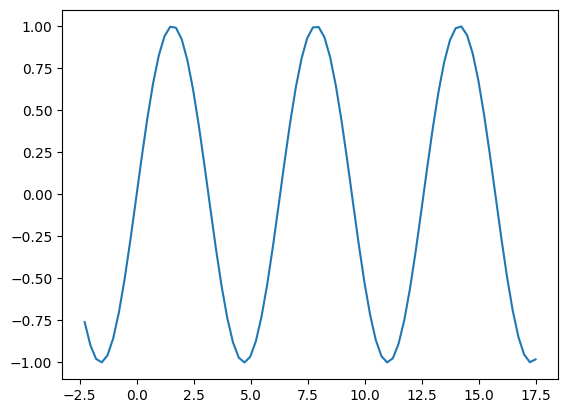

In [290]:
plt.plot(x[0], y[0])

In [291]:
#define hyper parameters and model weight tensors
B = 32 #batch size

#full tensor input size: [32 x 40]
#input x_t size [32 x 1]
#output from previous layer: h_t-1 [32 x 10]

SIZE = 50
Wxh = torch.randn((1, SIZE)) # [1 x 10] so x_t @ Wxh = [32 x 1] @ [1 x 10] --> [32 x 10]
Whh1 = torch.randn((SIZE, SIZE)) / SIZE**0.5 # [10 x 10] so h_t-1 @ Whh = [32 x 10] @ [10 x 10] --> [32 x 10]
Whh2 = torch.randn((SIZE, SIZE)) / SIZE**0.5 # [10 x 10] so Whh1 @ Whh2 = [32 x 10] @ [10 x 10] --> [32 x 10]
Whh3 = torch.randn((SIZE, SIZE)) / SIZE**0.5 # [10 x 10] so h_t-1 @ Whh = [32 x 10] @ [10 x 10] --> [32 x 10]
Whh4 = torch.randn((SIZE, SIZE)) / SIZE**0.5 # [10 x 10] so Whh1 @ Whh2 = [32 x 10] @ [10 x 10] --> [32 x 10]
Why = torch.randn((SIZE, 1)) / SIZE**0.5 # [10 x 1], to compute mse against y
bh1 = torch.randn(SIZE) #10-dim vector
bh2 = torch.randn(SIZE) #10-dim vector
bh3 = torch.randn(SIZE) #10-dim vector
bh4 = torch.randn(SIZE) #10-dim vector
by = torch.randn(1) #10-dim vector

params = [Wxh, Whh1, Whh2, Why, bh1, bh2, by]
for p in params:
    p.requires_grad = True

print(sum([p.numel() for p in params]))

5201


In [292]:
#forward pass

#sample a batch
sample_idx = np.random.choice(np.arange(x.shape[0]), size=B, replace=False)
x_batch = x[sample_idx, :]
y_batch = y[sample_idx, :]

#for each sample in batch, compute feedforward of network
loss = torch.zeros(1)
h_t = torch.zeros(1)
for i in range(x_batch.shape[1]):
    if i == 0:
        h_t = x_batch[:, i].unsqueeze(1) @ Wxh + bh1
    else:
        h_t = x_batch[:, i].unsqueeze(1) @ Wxh + h_t @ Whh1 + bh1
    h_t = torch.tanh(h_t)

    #adding an additional fully connected layer and
    h_t = h_t @ Whh2 + bh2
    h_t = torch.tanh(h_t)
    h_t = h_t @ Whh3 + bh3
    h_t = torch.tanh(h_t)
    h_t = h_t @ Whh4 + bh4
    h_t = torch.tanh(h_t)

    #generate predicted y value, compute loss for layer i
    y_pred = h_t @ Why + by
    loss += (y_batch[:, i].unsqueeze(1) - y_pred).square().mean() / B

#backpropagation
print(loss.item())
loss.backward()
lr = 0.00001
for p in params:
    p.data -= lr * p.grad
    p.grad = None

6.912010669708252


In [298]:
#consolidated into functions

def forward(x_batch, y_batch, store_outputs=False):
    #for each sample in batch, compute feedforward of network
    loss = torch.zeros(1)
    y_preds = []
    for i in range(x_batch.shape[1]):
        if i == 0:
            h_t = x_batch[:, i].unsqueeze(1) @ Wxh + bh1
        else:
            h_t = x_batch[:, i].unsqueeze(1) @ Wxh + h_t @ Whh1 + bh1
        h_t = h_t @ Whh2 + bh2
        h_t = torch.tanh(h_t)
        h_t = h_t @ Whh3 + bh3
        h_t = torch.tanh(h_t)
        h_t = h_t @ Whh4 + bh4
        h_t = torch.tanh(h_t)
    
        #generate predicted y value, compute loss for layer i
        y_pred = h_t @ Why + by
        if store_outputs:
            y_preds.append(y_pred)
        loss += (y_batch[:, i].unsqueeze(1) - y_pred).square().mean() / B
    return loss, y_preds

def backprop(loss, lr=0.0001):
    loss.backward()
    for p in params:
        p.data -= lr * p.grad
        p.grad = None

def train(n_iters=10000):
    losses = []
    for i in range(n_iters):
        #generate batch
        sample_idx = np.random.choice(np.arange(x.shape[0]), size=B, replace=False)
        x_batch = x[sample_idx, :]
        y_batch = y[sample_idx, :]
    
        loss, y_preds = forward(x_batch, y_batch)
        backprop(loss)
        if i % 100 == 0:
            #print(f'{i}: {loss.item()}')
            losses.append(loss.item())
    return losses
losses = train()

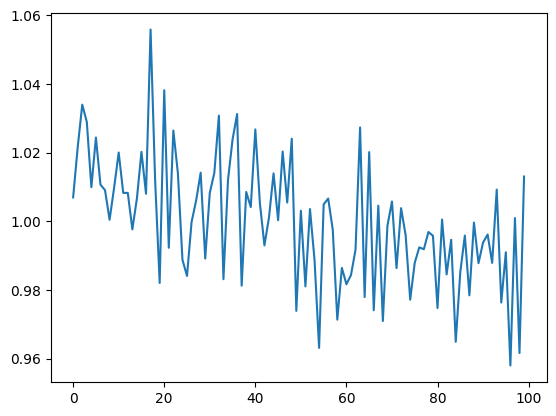

In [299]:
plt.plot(np.arange(len(losses)), losses)

In [286]:
#testing the trained functionality

x[0].shape, y[0].shape

(torch.Size([40]), torch.Size([40]))

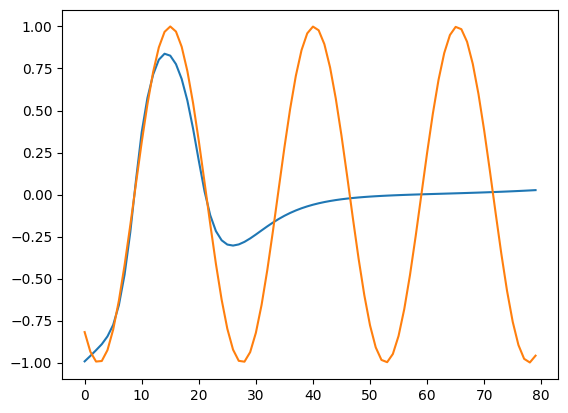

In [300]:
idx = 120
loss, y_preds = forward(x[idx].unsqueeze(0), y[idx].unsqueeze(0), True)
y_preds = [y.item() for y in y_preds]

plt.plot(np.arange(len(y_preds)), y_preds)
plt.plot(np.arange(len(y_preds)), x[idx].sin())

### Expanding to LSTMs

In [306]:
#initialize hyperparams, weights

B = 32 # batch size

#cat_in size = [32 x 2]
W_f = torch.randn() #[2 x FSIZE], so cat_in @ W_f --> [32 x FSIZE]
b_f = torch.randn() # [FSIZE]

W_i = torch.randn() #[2 x ISIZE]
b_i = torch.randn() # [ISIZE]

W_o = torch.randn() #[2 x OSIZE]
b_o = torch.randn() #[OSIZE]

W_c = torch.randn()
b_c = torch.randn()

W_y = torch.randn()
b_y = torch.randn()

params = [W_f, b_f, W_i, b_i, W_o, b_o, W_c, b_c, W_y, b_y]
for p in params:
    p.requires_grad = True

TypeError: randn() received an invalid combination of arguments - got (), but expected one of:
 * (tuple of ints size, *, torch.Generator generator, tuple of names names, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
 * (tuple of ints size, *, torch.Generator generator, Tensor out = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
 * (tuple of ints size, *, Tensor out = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
 * (tuple of ints size, *, tuple of names names, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)


In [ ]:
#forward pass

#sample a batch
sample_idx = np.random.choice(np.arange(x.shape[0]), size=B, replace=False)
x_batch = x[sample_idx, :]
y_batch = y[sample_idx, :]

#for each sample in batch, compute feedforward of network
loss = torch.zeros(1)
h_t, c_t = torch.zeros((B, 1)), torch.zeros((B, 1))
for i in range(x_batch.shape[1]):
    #gates and candidate hidden state
    cat_in = torch.cat([h_t, x_batch[:, i].unsqueeze(1)], dim=1)
    f_t = (cat_in @ W_f + b_f).sigmoid() #forget gate
    i_t = (cat_in @ W_i + b_i).sigmoid() #input gate
    o_t = (cat_in @ W_o + b_o).sigmoid() #output gate
    cc_t = torch.tanh(cat_in @ W_c + b_c) #candidate hidden state
    
    #update cell and hidden states
    c_t = f_t * c_t + i_t * cc_t #apply forget gate to previous cell state, input gate to candidate hidden state
    h_t = o_t * tanh(c_t) #new hidden state = output gate
    
    #generate predicted y value, compute loss for layer i
    y_pred = h_t @ W_y + b_y
    loss += (y_batch[:, i].unsqueeze(1) - y_pred).square().mean() / B

#backpropagation
print(loss.item())
loss.backward()
lr = 0.00001
for p in params:
    p.data -= lr * p.grad
    p.grad = None

In [305]:
torch.cat([torch.randn(32, 1), torch.randn(32, 1)], dim=1).shape

torch.Size([32, 2])